# Object Detection and Classification of Screws
The goal of this project is to use a dataset of photographs to train a model to detect and identify
an assorment of screws and nuts. The dataset was taken from the MVTec Screws Dataset. Object
detection is a challenging problem in machinelearning and continues to be a very active area of
research with new algorithms and processes being developed regularly.

In [2]:
from glob import glob, iglob
import os
import pathlib
import pprint as pp
from typing import List, Tuple, Union

import numpy as np
from numpy.typing import ArrayLike, NDArray

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Circle
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.collections import PolyCollection

import tensorflow as tf
from tensorflow.keras import Sequential, layers, losses, metrics
from tensorflow.keras.models import Model
from tensorflow.keras.utils import image_dataset_from_directory, load_img


from src.utils.funcs import init_COCO, process_img_annotations, rotate
from src.utils.classes import CategoricalDataGen, bbox_worker
from src.models.models import IoU, YOLOLoss
from src.utils.box_cutter import BoundingBox_Processor

from IPython.display import HTML

2023-01-04 22:35:18.114887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-04 22:35:18.318561: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
pp.PrettyPrinter(indent=4)

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2
%aimport src.utils.box_cutter
%aimport src.utils.funcs
%aimport src.utils.classes
%aimport src.models

### Data Cleaning/Preparation
The data presented several challenges when preparing it for training. The bounding-box format was
similar to the COCO format but did not seem to match what most plug and play tool chains expected.
This meant reworking the data multiple times and in a multitude of ways. 

Data manipulation led to the writing of several custom tools to handle various aspects of preparing
the data. These included:
* Tools to create coordinate points for bounding box corners from the row, col, width, height, angle format in the data.
* Tools to create compatible label formats for training.
* Tools to calculate IoU and GIoU for unaligned bounding boxes.
* Tools to provide necessary calculations from the label data to the loss function of a YOLO-like model.

## Initializing Data with Dataset Classes

In [6]:
data = init_COCO("./data/", ["train", "val", "test"])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [7]:
train = CategoricalDataGen('train', data, "./data/images", target_size=(384, 512))
val = CategoricalDataGen('val', data, "./data/images", target_size=(384, 512))
test = CategoricalDataGen('test', data, "./data/images", target_size=(384, 512))

In [10]:
X_train, y_train = np.empty((0, 384, 512, 3), dtype=np.float32), np.empty((0, 13), dtype=np.float32)
X_val, y_val = np.empty((0, 384, 512, 3), dtype=np.float32), np.empty((0, 13), dtype=np.float32)

for x, y in train.batch(batch_size=16):
    X_train = np.append(X_train, x, axis=0)
    y_train = np.append(y_train, y, axis=0)

for x, y in val.batch(batch_size=16):
    X_val = np.append(X_val, x, axis=0)
    y_val = np.append(y_val, y, axis=0)

## Data Understanding
The Dataset for this project consists of several hundred images of around 4500 thousand pieces of
construction hardware belonging to 13 different classes. The mostly represent types of common screws
however the images also contain nuts of varying sizes. Each size and type of hardware belongs to
its own class.

![EDA](./images/screws_with_label_boxes.png)

## Splitting Data into Single Class Images

In [14]:
!mkdir ./old/images_class

In [16]:
# val.crop_dataset("./old/images_class/")
train.crop_dataset("./old/images_class/")
test.crop_dataset("./old/images_class/")

In [18]:
train_ds = image_dataset_from_directory("./old/images_class/", 
                                        batch_size=32, 
                                        image_size=(128, 128),
                                        color_mode="rgb",
                                        shuffle=True)

val_ds = image_dataset_from_directory("./old/images_class/",
                                      batch_size=32,
                                      shuffle=True,
                                      color_mode="rgb",
                                      image_size=(128, 128))

Found 4427 files belonging to 3 classes.
Found 4427 files belonging to 3 classes.


![cropped classes](./images/cropped_classes.png)

# Model 1
This model did well at classifying the dataset, scoring around a %97 percent accuracy after only a few epochs. It consisted of a few convolutional blocks that feed two fully-connected dense layers that output the class probabilities.

In [19]:
def simple_classifier(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(16, 3, strides=2, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(32, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(64, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=1, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(13, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [23]:
classifier = simple_classifier((128, 128, 3), 13)
classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 global_average_pooling2d (G  (None, 128)              0     

In [24]:
classifier.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
history = classifier.fit(train_ds,
                         epochs=10,
                         batch_size=32,
                         validation_data=val_ds)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10.5, 5))

ax[0].plot(history.history['loss'], label="Training")
ax[0].plot(history.history['val_loss'], label="Validation")
ax[0].set_title('Sparse Categorical Crossentropy')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(history.history['accuracy'], label="Training")
ax[1].plot(history.history['val_accuracy'], label="Validation")
ax[1].set_title('Accuracy')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')

ax[0].legend()
ax[1].legend()
fig.suptitle("10 Epoch Simple Classifier", fontsize=18)

plt.savefig("/content/gdrive/MyDrive/colab_output/images/simple_model_10epoch.png")
plt.show(


![Simple Model Metrics](./images/simple_model_10epoch.png)


## Inspecting Convolution Layer Outputs
This method of inspecting individual layer responses to model inputs comes from Francois Chollet's book <i>Deep Learning with Python</i>

In [ ]:
layer_outputs = []
layer_names = []
for layer in classifier.layers:
    if isinstance(layer, (layers.Conv2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
activation_model = tf.keras.Model(inputs=classifier.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(val_ds.take(1))

### First Layer

In [ ]:
first_activation_layer = activations[0]

for img in range(first_activation_layer.shape[0]):
    fig, axs = plt.subplots(4, 4, figsize=(16, 16))
    for i, ax_row in zip(range(4), axs):
        for j, ax in zip(range(4), ax_row):
            ax.imshow(first_activation_layer[img, :, :, j+i], cmap='magma')
            ax.axis('off')
            ax.set_title(f"{img} filter {i+j+1}")
    plt.savefig(f'/content/gdrive/MyDrive/colab_output/images/conv_layer_outputs_{img:03d}.png')
    plt.close()

### All the Layers

In [ ]:
images_per_row = 16
for i_num in range(32):
    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros(((size + 1) * n_cols - 1,
                                images_per_row * (size + 1) - 1))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_index = col * images_per_row + row
                channel_image = layer_activation[i_num, :, :, channel_index].copy() 

                if channel_image.sum() != 0:
                    channel_image -= channel_image.mean()
                    channel_image /= channel_image.std()
                    channel_image *= 64
                    channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype("uint8")
                display_grid[col * (size + 1): (col + 1) * size + col,
                             row * (size + 1) : (row + 1) * size + row] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))

        plt.title(layer_name)
        plt.grid(False)
        plt.axis("off")
        plt.imshow(display_grid, aspect="auto", cmap="magma")
        plt.savefig(f"/content/gdrive/MyDrive/colab_output/images/conv_layers/{i_num}_conv_visualization_{layer_name}.png")
        plt.close()

# Model 2

## Model Layers Definition

In [ ]:
def conv2d_block(x, filters, kernel_size=3, reps:int=2, pooling:bool=False, **kwargs):
  residual = x
  options = {}
  if kwargs:
    options.update(**kwargs)
  for rep in range(reps):
    if not rep:
      options.update({'strides': 2})
    else:
      options['strides'] = 1
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(filters, kernel_size, padding="same", use_bias=False, **options)(x)
  
  if pooling:
    x = layers.MaxPooling2D(kernel_size, strides=2, padding="same")(x)
    # residual = layers.Conv2D(filters, 1, strides=2)(residual)
  # elif filters != residual.shape[-1]:
  #   residual = layers.Conv2D(filters, 1)(residual)
  
  # x = layers.add([x, residual])
  return x

In [ ]:
def conv2d_T_block(x, filters, kernel_size=3, reps:int=2, **kwargs):
  residual = x
  options = {'strides': 2}
  if kwargs:
    options.update(**kwargs)
  for rep in range(reps):
    if not rep:
      options.update({'strides': 2})
    else:
      options['strides'] = 1
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(filters, kernel_size, padding="same", use_bias=False, **options)(x)
  
  # residual = layers.Conv2D(filters, 1)(residual)
  
  # x = layers.add([x, residual])
  return x

# Model 2
## Model Defintion

My second iteration of the model attempted to use a model structure similar to an Autoencoder. Using
the bounding box labels from the dataset to make pixel masks of the classes I then tried several
different configurations to get the model to predict the class labeled masks from each image.

In [ ]:
def get_model(input_shape, filter_blocks:List, rescaling:bool=False, **kwargs):
    inputs = tf.keras.Input(shape=input_shape)
    if rescaling:
        x = layers.Rescaling(1./255)(inputs)
        x = layers.Conv2D(filter_blocks[0], kernel_size=5, padding='same', use_bias=False)(x)
    else:
        x = layers.Conv2D(filter_blocks[0], kernel_size=5, padding='same', use_bias=False)(inputs)

    for block in filter_blocks:
        x = conv2d_block(x, block, **kwargs)

        r_filter_blocks = reversed(filter_blocks)
    for t_block in r_filter_blocks:
        x = conv2d_T_block(x, t_block, **kwargs)

    outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
# Model Init and Config Values
filters = [32, 64, 128, 256, 512]
input_shape = x_2_train_final.shape[1:-1] + (1,)
print(input_shape)
clf_model = get_model(input_shape=input_shape, filter_blocks=filters)
clf_model.summary()

In [ ]:
clf_model.compile(optimizer="adam", loss=ssim_loss(), metrics=["MeanSquaredError", "Poisson"])

In [ ]:
history = clf_model.fit(x_2_train_final, x_2_train_final, 
                    epochs=28,
                    batch_size=32,
                    # callbacks = callbacks,
                    validation_data=(x_2_test_final, x_2_test_final))

In [ ]:
num = len(history.history.keys()) / 2
metric = (key for key in history.history.keys())
fig, ax = plt.subplots(2, 2, figsize=(8, 1.5*num))
for j in range(2):
  for i in range(int(num/2)):
    this_metric = next(metric)
    ax[i, j].plot(history.history[this_metric])
    ax[i, j].plot(history.history[f"val_{this_metric}"])
    ax[i, j].set_title(f'{this_metric}'.title())
    ax[i, j].set(xlabel="Epochs", ylabel="Loss")
plt.savefig(f"{image_path}/ssim_output_graph_{run_count:03d}.png")
fig.tight_layout()
plt.show()

# Model 3 - WIP

After spending a significant amount of time researching image detection methods and algorithms I
decided to try to implement a simple version of the YOLO algorithm with my dataset.

## Preparing Data and writing functions to calculate IoU and GIoU

In [29]:
data = init_COCO("./data/", ["train", "val", "test"])
test = CategoricalDataGen('test', data, "./data/images", target_size=(384, 512))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Found 269 train images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 55 val images
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Found 60 test images


In [30]:
# Defining the number of divisions the anchor boxes and loss function should use
xdivs = 12
ydivs = 9
# Calling my dataset class and using it's get_labels function to dervive the correctly formatted data from the dataset
labels = test.get_labels(divs=(ydivs, xdivs), num_classes=13, num_boxes=3,
                input_size=(1440, 1920))
labels.shape

(60, 12, 9, 19)

### Generating "predictions" to check my calculations

In [32]:
# Initialize an array with zeros
# The shape is (batch_size, x_division, y_division, 13(classes) + 3(boxes) * 6(x, y, width, height, angle))
preds = np.zeros((60, xdivs, ydivs, 13 + 3 * 6), dtype=np.float32)

# add our label tensor to it; the model predicts three anchor boxes for each grid cell so we create three predictions
preds[...,:19] = preds[...,:19] + labels
preds[..., 19:25] = labels[..., 13:19] 
preds[..., 25:] = labels[..., 13:19] bb
# b_e means "box exists" it is the probability score that a box is present in the cell.
# we can also use this value (here is is always equal to the true value) to reduce rows we that do not contain values to zero
b_e = preds[..., 13]
b_e = b_e.reshape((preds.shape[:-1] + (1,)))
print(b_e.shape)
box_exists = np.concatenate((b_e, b_e, b_e, b_e, b_e), axis=-1)
# establishing a known loss for the first anchor box prediction so that I can follow the calculations for a sanity check
# if it becomes necessary
known_loss = np.asarray([10, 10, 5, 20, np.pi * .05])
known_loss = np.full(preds.shape[:-1] + (5,), known_loss, dtype=np.float32)

# generating the loss values and adding them to the prediction tensor
preds[..., 14:19] = known_loss + preds[..., 14:19]
preds[..., 20:25] = box_exists * (preds[..., 20:25] + np.random.normal(0, 2, preds.shape[:-1] + (5,)))
preds[..., 26:] = box_exists * (preds[..., 26:] + np.random.normal(0, 2, preds.shape[:-1] + (5,)))

(60, 12, 9, 1)


### Box Cutter
I wrote a class to handle the many operations that need to happen.

The purpose of these operations is to compare the <b>True Labels</b> with the <b>Predicted Labels</b>. All of these methods are chains of tensor operations. Please remember that the labels are structured as a center point (x,y), a width and height, and an angle of alignment (the angle the bound box is pointing in radians).

So to calculate IoU and GIoU I have to:
* Calculate the actual x, y values for each corner point
* Calculate the intersections of the edges between the True bounding box and the Prediction
* Check for corners floating in the middle of either bounding box
* Return the intersections and 'inside' corners as a points of a polygon (this will be a different number of points for each pair in the two tensors)
* Calculate the are of that n-sided polygon, this is the Intersection
* Calculate IoU
* Find the smallest rectangle that encompasses both boxes, and it's area
* Calculate GIoU

<b>Let's go!</b>

In [33]:
# Initializing a class I wrote to perform a complicated chain of tensor operations
box_cutter = BoundingBox_Processor()

In [34]:
# The first step was to extract the corner point x, y values from the labels
label_corners = box_cutter.get_corners(labels)
pred_corners = box_cutter.get_corners(preds)
pred_corners = pred_corners[0]
label_corners = label_corners[0]
print(pred_corners.shape)

(60, 12, 9, 4, 2)


In [35]:
# Then I wrote a class method that extracts the edges of each bounding box in the tensors
true_edges = box_cutter.get_edges(label_corners)
pred_edges = box_cutter.get_edges(pred_corners)
print(pred_edges.shape)

(60, 12, 9, 4, 2, 2)


In [36]:
intersection_points = box_cutter.construct_intersection(label_corners, pred_corners, return_centered=False)

### Skipping to the End
All of the cool code is in the box_cutter.py file in src/

Below you can see the culmination of all that work. Nan values are cells where there is no bounding box.

In [37]:
iou = box_cutter.calculate_iou(label_corners, pred_corners)
print(f"IoU: {iou.shape}\n{iou[0, 5]}")

IoU: (60, 12, 9)
[       nan        nan        nan        nan 0.19630685        nan
 0.42729294        nan 0.49481216]


In [38]:
giou = box_cutter.calculate_GIoU(label_corners, pred_corners)
giou[0, 5]

C shape (60, 12, 9)
Union: (60, 12, 9)
Intersection: (60, 12, 9)


<tf.Tensor: shape=(9,), dtype=float32, numpy=
array([       nan,        nan,        nan,        nan, 0.19596088,
              nan, 0.42720267,        nan, 0.49470305], dtype=float32)>

## Taking a Look

In [39]:
test_box = label_corners[0, :, :]
test_pred = pred_corners[0, :, :]
test_intr = tf.constant(intersection_points[0, :, :, :8])

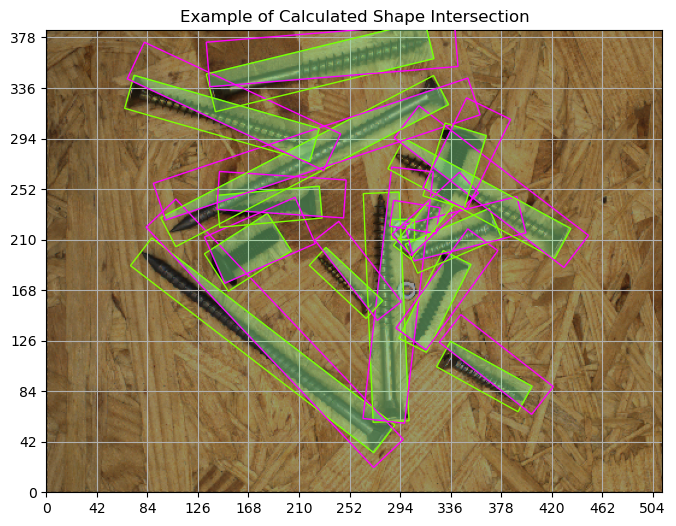

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set(
        xlim=[0, 512],
        ylim=[0, 384],
        xticks=list(range(0, 512,int(512/12))),
        yticks=list(range(0, 384, int(384/9))),
        )
ax.grid(visible=True, zorder=0)
ax.set_title("Example of Calculated Shape Intersection")
ax.imshow(np.asarray(load_img("./data/images/test/screws_006.png", target_size=(384, 512))), zorder=0, alpha=.6)
ax.set_facecolor('black')
for cell in range(12 * 9):
    cl = divmod(cell, 12) 
    check = tf.cast(tf.reduce_sum(test_box[cl[1], cl[0]]) < .001, dtype=tf.bool).numpy()
    if check:
        continue
    mask = tf.cast(tf.reduce_sum(test_intr[cl[1], cl[0]], axis=-1) > 0.001, dtype=tf.bool)
    test_inter_ma = tf.boolean_mask(test_intr[cl[1], cl[0]], mask)
    ax.add_patch(Polygon(test_box[cl[1], cl[0]], fill=None, edgecolor='chartreuse', lw=1, zorder=20))
    ax.add_patch(Polygon(test_pred[cl[1], cl[0]], fill=None, edgecolor='fuchsia', lw=1, zorder=20))
    ax.add_patch(Polygon(test_inter_ma, facecolor='palegreen', edgecolor='springgreen', lw=1, alpha=.4, zorder=10))
ax.axhline(0, -10, 10, lw=1, color='black', linestyle='--', zorder=5)
ax.axvline(0, -10, 10, lw=1, color='black', linestyle='--', zorder=5)
plt.savefig("./images/bbox_intersection.png")
plt.show()

## Animating the Visualization

#### This function just searches the tensor and returns polygon patches whenever it finds a valid bounding box

In [43]:
def find_cells(test_box, test_pred, test_intr):
    result = []
    x_dim, y_dim = test_box.shape[0:2]
    for cell in range(x_dim * y_dim):
        x, y = divmod(cell, x_dim) 
        check = tf.cast(tf.reduce_sum(test_box[y, x]) < .001, dtype=tf.bool).numpy()
        if check:
            continue
        mask = tf.cast(tf.reduce_sum(test_intr[y, x], axis=-1) > 0.001, dtype=tf.bool)
        y_intr = tf.boolean_mask(test_intr[y, x], mask)
        y_true = test_box[y, x]
        y_pred = test_pred[y, x]
        result.append((y_true, y_pred, y_intr)) 
    return result

In [44]:
# Call the function
poly_list = find_cells(test_box, test_pred, test_intr)

In [47]:
fig, ax = plt.subplots(figsize=(8,6))
def animation(i):
    if i > 0:
        ax.clear()
    ax.tick_params(axis="both",
                   which="both",
                   bottom=False,
                   left=False,
                   labelbottom=False,
                   labelleft=False)
    ax.set(
            xlim=[0, 512],
            ylim=[0, 384],
            xticks=list(range(0, 512,int(512/12))),
            yticks=list(range(0, 384, int(384/9))),
            # yticklabels=np.linspace(0, 9, 10),
            # xticklabels=np.linspace(0, 12, 13)
            )
    ax.grid(visible=True, color="black", zorder=0)
    ax.set_title("Example of Calculated Shape Intersection")
    ax.imshow(np.asarray(load_img("./data/images/test/screws_006.png", target_size=(384, 512))), zorder=0, alpha=1)
    ax.add_patch(Polygon(poly_list[i][0], fill=None, edgecolor='chartreuse', lw=1, zorder=20))
    ax.add_patch(Polygon(poly_list[i][1], fill=None, edgecolor='fuchsia', lw=1, zorder=20))
    ax.add_patch(Polygon(poly_list[i][2], facecolor='palegreen', edgecolor='springgreen', lw=1, alpha=.5, zorder=10))

anim = FuncAnimation(fig, animation, frames=len(poly_list))
# anim.save("./images/intr_anim3.gif", fps=1)
HTML(anim.to_jshtml(fps=1))
plt.close()

![animated boxes](./images/intr_anim3.gif)

# Model 4 - Final Model
For my final object detection attempt I used a YOLO implmentation written with Darknet. Darknet is
a Machine-Learning framework written in C and provides a python api and many versions of models with trained 
weights. I am using the YOLOv3 implementation in darknet and trained it using a set of weights from
COCO and my own data. 

It was relatively easy to set up and get training. There were small adjustments I need to make to
my dataset and simple scripts to translate my labels to a format darknet will accept. In order to
use this framework I removed the angle parameter from the labels and recalculated the points to 
match what darknet expects.

To run this section you would need to have my directory and project structure in place. This is currently only run on Google Colab, so I don't have a local version of the project.

I will paste the code below though, with the steps needed to setup, train and validated <b>darknet</b>.

## darknet setup

In [ ]:
!git clone https://github.com/AlexeyAB/darknet
# You need to clone the repo into your working directory (/content/ on Colab)

In [ ]:
%cd darknet
# These make edits to the C make file to tell it to compile for running on a GPU
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefil

In [ ]:
# compile darknet
!make

### My environment Setup
* Connect Colab VM to my Google Drive
* Copy tar balls containing my project files over to the VM
* Unpack the folders and copy all the files into their correct positions
* Copy the latest weights file over from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive'

In [ ]:
!cp /content/gdrive/MyDrive/yoloV3/yolo_v3_0104.tar.gz /content/
!cp /content/gdrive/MyDrive/yoloV3/images_yolo_0103.tar.gz /content/
!cp /content/gdrive/MyDrive/yoloV3/yolov3_5l_last.weights /content/darknet/
!tar -xf /content/yolo_v3_0104.tar.gz
!tar -xf /content/images_yolo_0103.tar.gz

In [ ]:
!mkdir /content/darknet/data/obj
!cp /content/yolo_v3/obj/* /content/darknet/data/obj/
!cp /content/yolo_v3/obj.* /content/darknet/data/
!cp /content/images/train/* /content/darknet/data/obj/
!cp /content/images/val/* /content/darknet/data/obj/
!cp /content/images/test/* /content/darknet/data/obj/
!cp /content/yolo_v3/yolov3_5l.cfg /content/darknet/cfg/

## Train, or Test darknet
To train you need to edit the cfg file and pass 'train' instead of 'test' as a commandline argument. My darknet model is still training with a loss of around .55. I will add a result from an earlier set of weights that leaves quite a bit to be desired.

There is probably a mismatch between the way that darknet displays the coordinates and the way they are structured in the dataset, because the class predictions are not too bad, but the box predictions are not displayed correctly.

Because I do not have direct access to the predictions of the model it is hard to check without retraining the model on a different label configuration. I will continue to tweak it, but until I can track down the source of this problem it is displaying the bounding boxes badly.

In [ ]:
!./darknet detector test data/obj.data cfg/yolov3_5l.cfg yolov3_5l_last.weights /content/images/train/screws_004.png -thresh 0.6

![darknet output](./images/darknet_output.png)